# Coffe Classifier: Thesis project for Bythem

## Imports

In [1]:
import tensorflow_model_optimization as tfmot
import tf_keras as keras
import tensorflow as tf
import numpy as np

from preprocessing import dataset_preprocessing, tensorflow_to_numpy_dataset
from custom_mobilenet_v2 import MobileNet_v2
from plotting import plot_training_history, plotting_confusion_matrix, plot_test_images,plot_test_images_lite
from utils import get_zipped_model_size, print_model_weights_sparsity
from evaluation import evaluate_lite_model


print('TensorFlow version: ', keras.__version__)


TensorFlow version:  2.16.0


## Parameters and Hyperparameters

In [2]:
BATCH_SIZE = 16
IMAGE_SIZE = 224
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
EPOCHS = 70
DROPOUT = 0.2
SCALE = 127.5
OFFSET = -1

PRUNING_EPOCHS = 3
INITIAL_SPARSITY = 0.20
FINAL_SPARSITY = 0.60

dataset_1 = "..\coffe_dataset"

PATH = dataset_1

## Dataset loading and preprocessing

In [3]:
dataset = keras.utils.image_dataset_from_directory(PATH,
                                                   shuffle = True,
                                                   batch_size = BATCH_SIZE,
                                                   image_size = (IMAGE_SIZE, IMAGE_SIZE))

class_names = dataset.class_names
number_classes = len(class_names)

training_dataset, validation_dataset, testing_dataset = dataset_preprocessing(dataset,
                                                                              train_size=0.60,
                                                                              validation_size=0.17, 
                                                                              augmentation_flag = True, 
                                                                              rescaling_flag = True, 
                                                                              prefetch_flag = True, 
                                                                              scale = SCALE, 
                                                                              offset = OFFSET)

Found 1379 files belonging to 9 classes.



In [4]:
class_names

['cioccolata',
 'cioccolata senza paletta',
 'espresso',
 'espresso senza paletta',
 'macchiato',
 'macchiato senza paletta',
 'the',
 'the senza paletta',
 'vuoto']

In [5]:
print('Number of training images:', len(training_dataset)*BATCH_SIZE)
print('Number of validation images:', len(validation_dataset)*BATCH_SIZE)
print('Number of testing images:', len(testing_dataset)*BATCH_SIZE)

Number of training images: 832
Number of validation images: 224
Number of testing images: 336


## **Create model**

Load pre-trained model

In [6]:
pre_trained_model = keras.applications.MobileNetV2(input_shape = INPUT_SHAPE, 
                                                   include_top=False, 
                                                   weights='imagenet',
                                                   alpha=0.35,
                                                   classes=number_classes)

Set weights from pre_trained model and freeze a % of the pre-trained model for transfer learning

In [7]:
model = MobileNet_v2(input_shape=INPUT_SHAPE, alpha=0.35, num_classes=number_classes, dropout=DROPOUT)

count = 0
for i, layer in enumerate(pre_trained_model.layers):
        model.layers[i].set_weights(layer.get_weights())
        count = count +1 

for i in range(int(count*1)):
    model.layers[i].trainable= False

Compile and train model

In [8]:
model.compile(optimizer = keras.optimizers.Adam(1e-3),
              loss= keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True)

history = model.fit(training_dataset,
                    validation_data=validation_dataset,
                    epochs=EPOCHS,
                    callbacks=[early_stopping])

Epoch 1/70


52/52 [==============================] - 96s 728ms/step - loss: 1.4280 - accuracy: 0.4664 - val_loss: 0.9328 - val_accuracy: 0.7366
Epoch 2/70
52/52 [==============================] - 9s 166ms/step - loss: 0.8498 - accuracy: 0.7534 - val_loss: 0.6515 - val_accuracy: 0.8170
Epoch 3/70
52/52 [==============================] - 9s 171ms/step - loss: 0.6180 - accuracy: 0.8095 - val_loss: 0.5301 - val_accuracy: 0.8348
Epoch 4/70
52/52 [==============================] - 9s 171ms/step - loss: 0.4973 - accuracy: 0.8474 - val_loss: 0.4169 - val_accuracy: 0.8571
Epoch 5/70
52/52 [==============================] - 9s 181ms/step - loss: 0.3980 - accuracy: 0.8730 - val_loss: 0.3667 - val_accuracy: 0.8839
Epoch 6/70
52/52 [==============================] - 9s 178ms/step - loss: 0.3163 - accuracy: 0.9023 - val_loss: 0.3217 - val_accuracy: 0.8795
Epoch 7/70
52/52 [==============================] - 9s 183ms/step - loss: 0.2756 - accuracy: 0.9084 - val_loss: 0.3134 - val_accuracy: 0.8884
Epo

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 16)         432       ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 112, 112, 16)         0         ['batch_normalization[0][0

Plotting training history

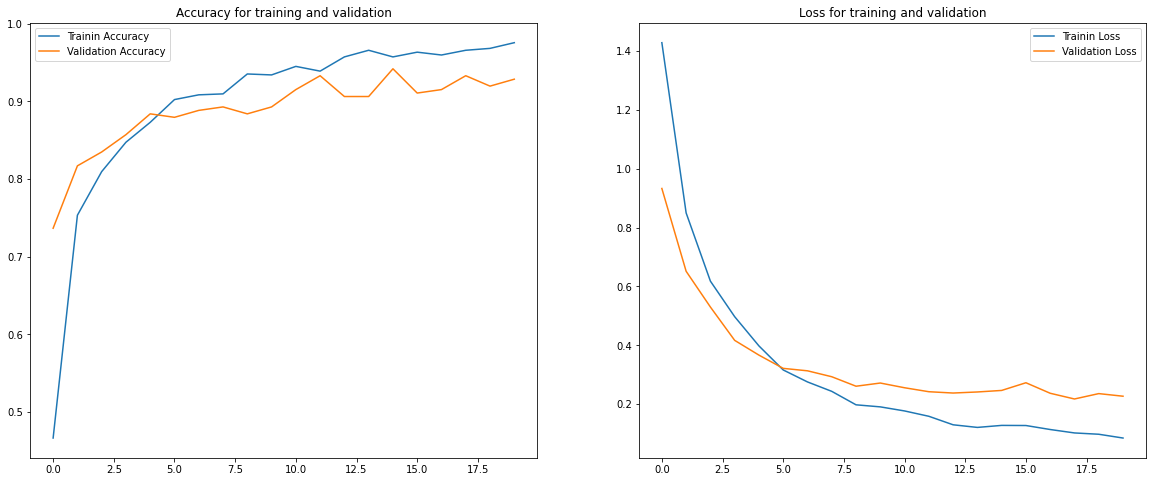

In [10]:
plot_training_history(history)

In [11]:
model.save('saved_models/prova.keras')

### Test model

Accuracy

In [12]:
_, baseline_accuracy = model.evaluate(testing_dataset, verbose = 0)
print('Accuracy: ', round(baseline_accuracy*100, 3), '%')

Accuracy:  95.833 %


Confusion matrix

11/11 [==============================] - 10s 229ms/step


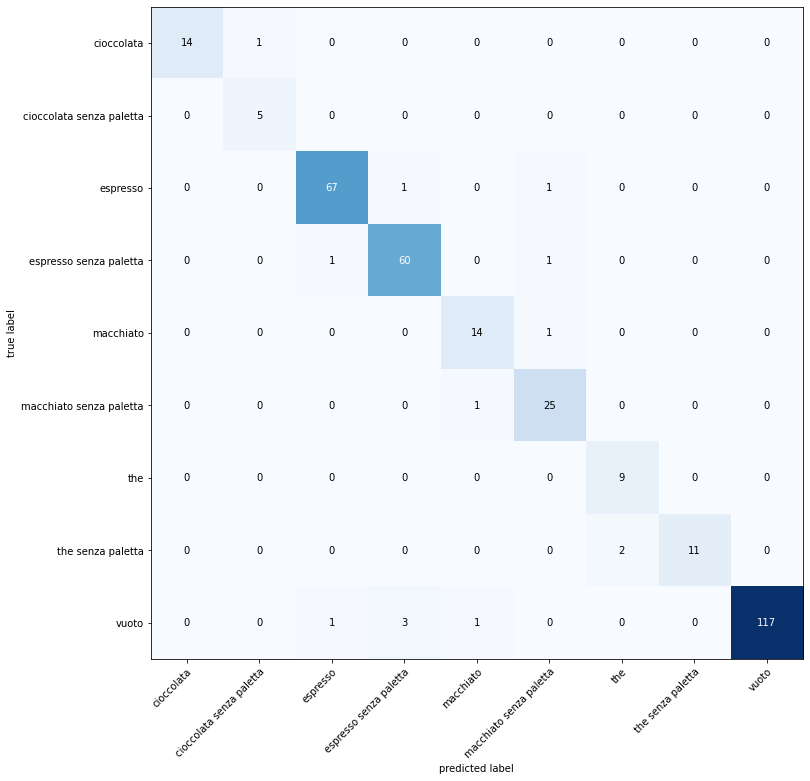

In [13]:
plotting_confusion_matrix(testing_dataset, model, class_names)

Check on some test images

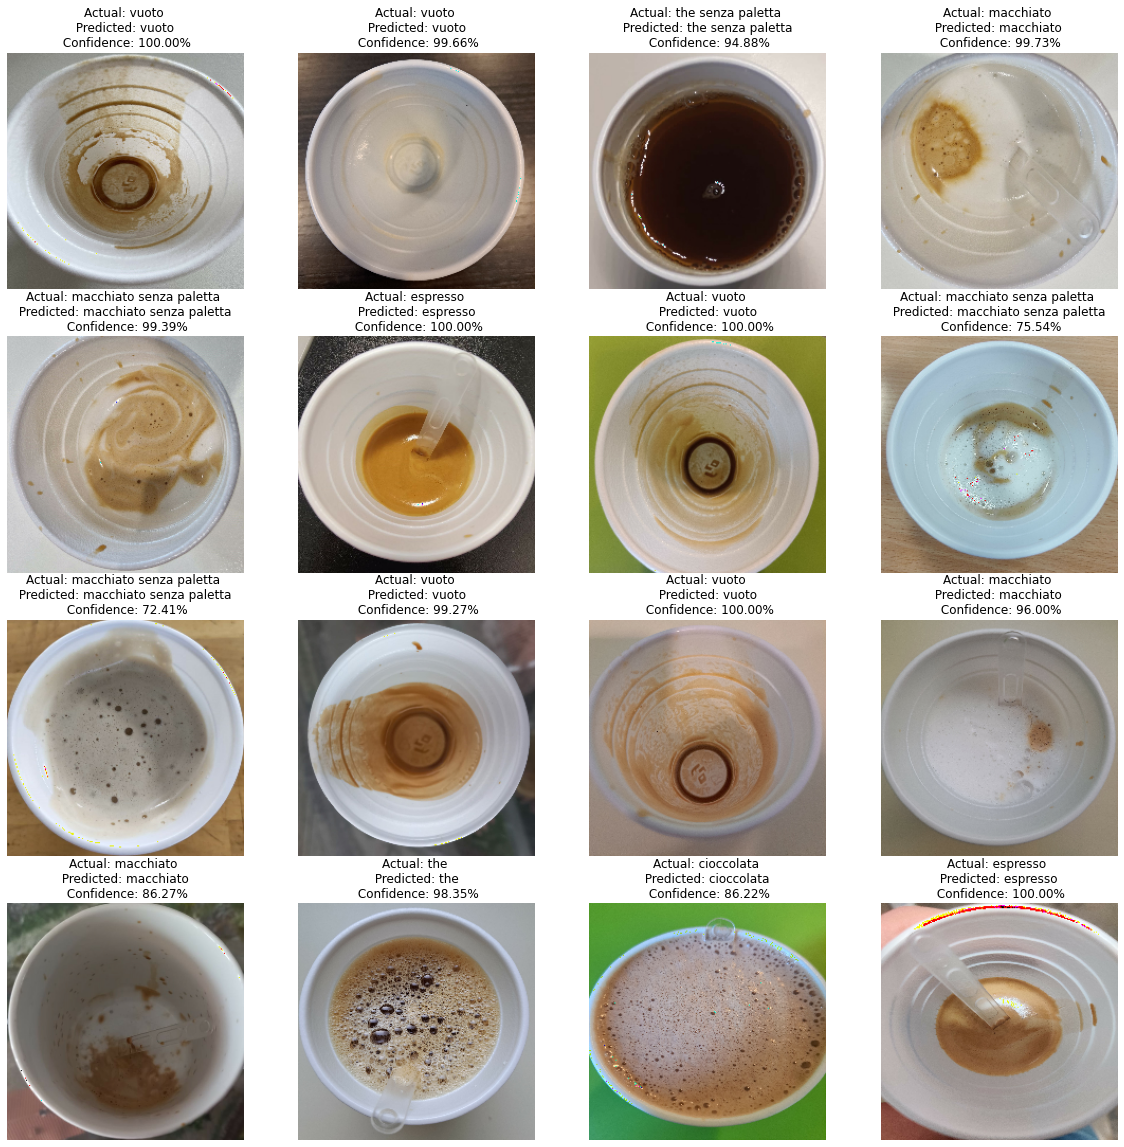

In [14]:
plot_test_images(model, testing_dataset, class_names, num_images = 16, scaling = SCALE, offset=OFFSET)

## **Pruning Model**

In [15]:
model = keras.models.load_model('saved_models/prova.keras')
_, baseline_accuracy = model.evaluate(testing_dataset, verbose = 0)
print('Baseline accuracy: ', round(baseline_accuracy*100, 3), '%')

Baseline accuracy:  95.833 %


In [16]:
model.trainable= True

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

num_images = (len(training_dataset)) *BATCH_SIZE
end_step = np.ceil(num_images / BATCH_SIZE).astype(np.int32) * PRUNING_EPOCHS


pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=INITIAL_SPARSITY, 
                                                             final_sparsity=FINAL_SPARSITY,
                                                             begin_step=0, 
                                                             end_step=end_step,
                                                             frequency = 30)}
''' 
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.5,
                                                              begin_step=0,
                                                              frequency=100)}
'''

pruned_model = prune_low_magnitude(model, **pruning_params)

callbacks = [tfmot.sparsity.keras.UpdatePruningStep()]

pruned_model.compile(optimizer= keras.optimizers.Adam(learning_rate=1e-5),
                     loss= keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                     metrics=['accuracy'])


# Fine tune the model
pruned_model.fit(training_dataset,
                 validation_data=validation_dataset,
                 epochs= PRUNING_EPOCHS,
                 verbose=1,
                 callbacks=callbacks)

Epoch 1/3
52/52 [==============================] - 130s 930ms/step - loss: 4.2686 - accuracy: 0.4261 - val_loss: 1.3253 - val_accuracy: 0.5223
Epoch 2/3
52/52 [==============================] - 31s 599ms/step - loss: 3.0301 - accuracy: 0.4347 - val_loss: 4.9317 - val_accuracy: 0.1518
Epoch 3/3
52/52 [==============================] - 31s 604ms/step - loss: 2.1652 - accuracy: 0.4811 - val_loss: 2.5091 - val_accuracy: 0.3750


In [17]:
pruned_model.compile(optimizer = keras.optimizers.Adam(1e-3),
              loss= keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True )

pruned_model.fit(training_dataset,
                 validation_data=validation_dataset,
                 epochs=EPOCHS,
                 callbacks=[early_stopping])

Epoch 1/70
52/52 [==============================] - 110s 754ms/step - loss: 0.9308 - accuracy: 0.7192 - val_loss: 1.1397 - val_accuracy: 0.5670
Epoch 2/70
52/52 [==============================] - 29s 560ms/step - loss: 0.2829 - accuracy: 0.9035 - val_loss: 0.7064 - val_accuracy: 0.7634
Epoch 3/70
52/52 [==============================] - 30s 574ms/step - loss: 0.1188 - accuracy: 0.9707 - val_loss: 0.5792 - val_accuracy: 0.8214
Epoch 4/70
52/52 [==============================] - 30s 579ms/step - loss: 0.0753 - accuracy: 0.9805 - val_loss: 0.4891 - val_accuracy: 0.8348
Epoch 5/70
52/52 [==============================] - 30s 581ms/step - loss: 0.0336 - accuracy: 0.9963 - val_loss: 0.1757 - val_accuracy: 0.9375
Epoch 6/70
52/52 [==============================] - 30s 580ms/step - loss: 0.0392 - accuracy: 0.9939 - val_loss: 0.2881 - val_accuracy: 0.9241
Epoch 7/70
52/52 [==============================] - 30s 584ms/step - loss: 0.0402 - accuracy: 0.9902 - val_loss: 0.1914 - val_accuracy: 0.950

In [18]:
_, pruned_accuracy = pruned_model.evaluate(testing_dataset, verbose = 0)
print('Baseline accuracy: ' , round(100* baseline_accuracy,3),  '%')
print('Pruned accuracy: '   , round(100* pruned_accuracy,3) ,   '%')

Baseline accuracy:  95.833 %
Pruned accuracy:  95.833 %


In [19]:
stripped_pruned_model = tfmot.sparsity.keras.strip_pruning(pruned_model)
stripped_pruned_model.save('saved_models/prova_pruned.keras')

In [20]:
print_model_weights_sparsity(stripped_pruned_model)

conv2d/kernel:0: 59.95% sparsity  (259/432)
batch_normalization/gamma:0: 0.00% sparsity  (0/16)
batch_normalization/beta:0: 0.00% sparsity  (0/16)
batch_normalization/moving_mean:0: 0.00% sparsity  (0/16)
batch_normalization/moving_variance:0: 0.00% sparsity  (0/16)
depthwise_conv2d/depthwise_kernel:0: 0.00% sparsity  (0/144)
batch_normalization_1/gamma:0: 0.00% sparsity  (0/16)
batch_normalization_1/beta:0: 0.00% sparsity  (0/16)
batch_normalization_1/moving_mean:0: 0.00% sparsity  (0/16)
batch_normalization_1/moving_variance:0: 0.00% sparsity  (0/16)
conv2d_1/kernel:0: 60.16% sparsity  (77/128)
batch_normalization_2/gamma:0: 0.00% sparsity  (0/8)
batch_normalization_2/beta:0: 0.00% sparsity  (0/8)
batch_normalization_2/moving_mean:0: 0.00% sparsity  (0/8)
batch_normalization_2/moving_variance:0: 0.00% sparsity  (0/8)
conv2d_2/kernel:0: 59.90% sparsity  (230/384)
batch_normalization_3/gamma:0: 0.00% sparsity  (0/48)
batch_normalization_3/beta:0: 0.00% sparsity  (0/48)
batch_normalizat

In [21]:
print("Pruned model size: ", get_zipped_model_size('saved_models/prova_pruned.keras')/10**6, ' MB')

Pruned model size:  1.002627  MB


## **Quantize model**

### Post-training quantization

In [22]:
images_batch_np, labels_batch_np = tensorflow_to_numpy_dataset(testing_dataset)

def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(images_batch_np).batch(1).take(100):
    yield [input_value]


converter = tf.lite.TFLiteConverter.from_keras_model(stripped_pruned_model);
converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

pruned_model_integer_quantization = converter.convert()


INFO:tensorflow:Assets written to: C:\Users\ALESSA~1\AppData\Local\Temp\tmpmerp9k7o\assets


INFO:tensorflow:Assets written to: C:\Users\ALESSA~1\AppData\Local\Temp\tmpmerp9k7o\assets
C:\Users\ALESSANDRO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tensorflow\lite\python\convert.py:964: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [23]:
with open("saved_lite_models/pq_prova.tflite", "wb") as f:
    f.write(pruned_model_integer_quantization)    

## **Check for size and compression**

In [24]:
#print("Original model size: ", get_zipped_model_size('saved_models/mobilenetv2_0.35_224.keras')/10**6, ' MB')
print("Pruned model size: ", get_zipped_model_size('saved_models/prova_pruned.keras')/10**6, ' MB')
#print("PQAT model size: ", get_zipped_model_size(pqat_model_file)/10**3, ' KB')
print("Compressed model size: ", get_zipped_model_size('saved_lite_models/pq_prova.tflite')/10**3, ' kB')

Pruned model size:  1.002627  MB
Compressed model size:  344.817  kB


## **Test compressed model**

Processing test dataset. Batch to process:  21 

Accuracy of compressed model model: 94.94 %


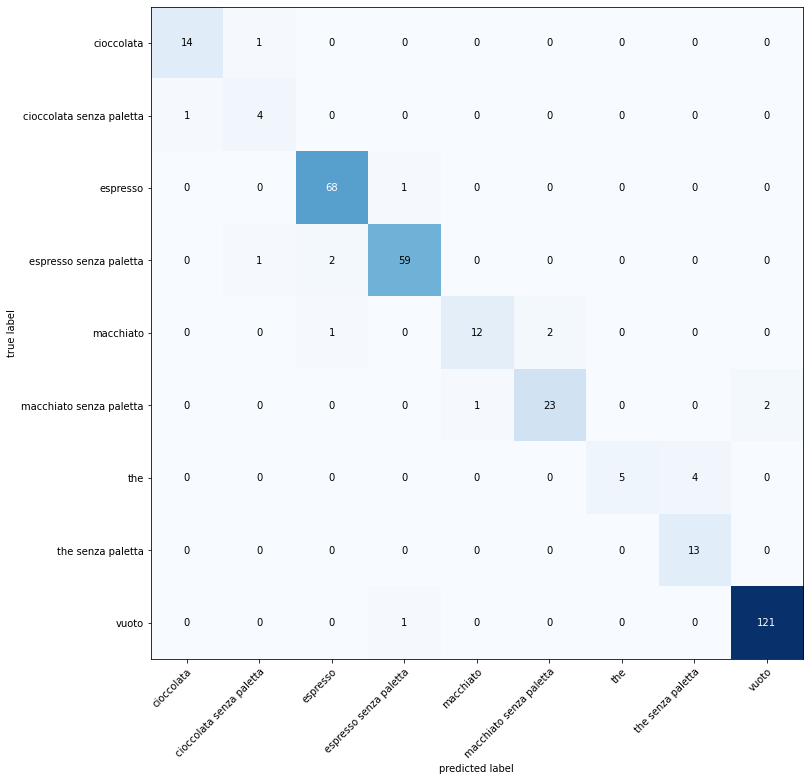

In [25]:
interpreter = tf.lite.Interpreter(model_path='saved_lite_models/pq_prova.tflite')
interpreter.allocate_tensors()

accuracy = evaluate_lite_model(interpreter, testing_dataset, class_names=class_names, show_confusion_matrix=True)
print("Accuracy of compressed model model: %.2f" %(accuracy*100) , '%')

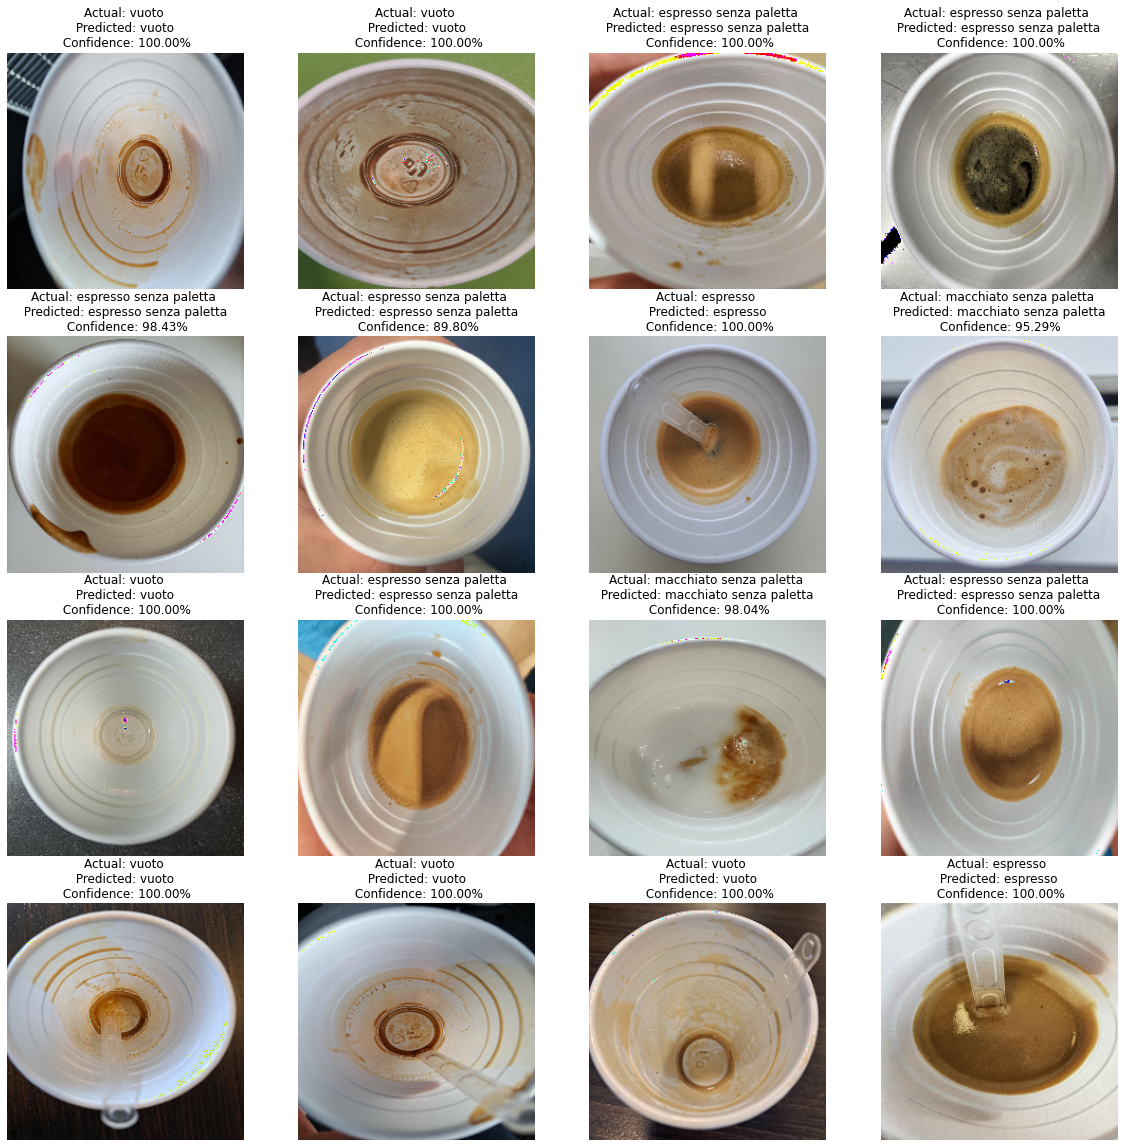

In [26]:
plot_test_images_lite(interpreter, testing_dataset, class_names, num_images = 16, scaling = SCALE, offset=OFFSET)